# Cyclical Learning Rate
- Testing perf on CIFAR10
- Using caffe cifar10 convnet architecture hinted in paper
- Choosing hyperparams based on suggested LR range test
- CLR peforms indeed better (by 1-3% over Adam)
- Training is relatively stable, re-running multiple times produces similar results
- Hyperparams are relatively soft, reasonable changes in lr_min, lr_max and stepsize still produce competitive results 

### Structure
- 0. Data loading
- 1. Model configuration
- 2. Training (hyperparam selection and benchmarking)
- 3. Training stability
- 4. Parameter sensitivity

In [34]:
import os
import copy
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt

import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.optim import Adam, SGD, RMSprop
from torch.optim.lr_scheduler import LambdaLR, CyclicLR

%load_ext blackcellmagic

plt.rcParams["figure.figsize"] = (25, 4)
device = "cuda:0" if torch.cuda.is_available() else "cpu"

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


## 0. Data

In [2]:
ds_path = os.environ["MS_DATASETS_PATH"]

ds_train = CIFAR10(root=f"{ds_path}/CIFAR10", train=True, 
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                ]))
ds_test = CIFAR10(root=f"{ds_path}/CIFAR10", train=False,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                ]))

## 1. Model
- https://github.com/BVLC/caffe/blob/master/examples/cifar10/cifar10_quick_train_test.prototxt
- I think we has hinting to this one

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.fcn = nn.Sequential(
            nn.Linear(576, 64), 
            nn.ReLU(), 
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        out = self.conv(x)
        out = out.view(len(out), -1)
        out = self.fcn(out)
        return out

## 2. Training
- Logging every 10 iterations
- CrossEntropy loss
- Batch size 100

In [4]:
batch_size = 100
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=10000, shuffle=False)
test_X, test_y = (x.to(device) for x in next(iter(test_loader)))


def train(model, optimiser, scheduler=None, n_epochs=20):
    logger = defaultdict(list)
    for epoch_ix in range(n_epochs):
            for batch_ix, (batch_X, batch_y) in enumerate(train_loader):
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                optimiser.zero_grad()
                out = model(batch_X)
                loss = criterion(out, batch_y)
                loss.backward()
                optimiser.step()
                
                if scheduler:
                    scheduler.step()

                if batch_ix % 10 == 0:
                    logger["train_loss"].append(loss.detach().cpu().item())
                    test_loss, test_acc = evaluate(model, test_X, test_y)
                    logger["test_loss"].append(test_loss)
                    logger["test_acc"].append(test_acc)
                    if scheduler:
                        logger["lr"].append(scheduler.get_lr()[0])
    return logger


def evaluate(model, X, y) -> (float, float):
    """:return: loss, acc"""
    out = model(X)
    _, preds = torch.max(out.data, 1)
    correct = (preds == y).sum().item()
    acc = correct / len(y)
    loss = criterion(out, y).detach().cpu().item()
    return loss, acc

### 2.1 LR Range Test
- test suggested in paper, running model continously for n epochs and increasing lr linearly
- "optimal" lr_min seems to be 0.005 and lr_max 0.03

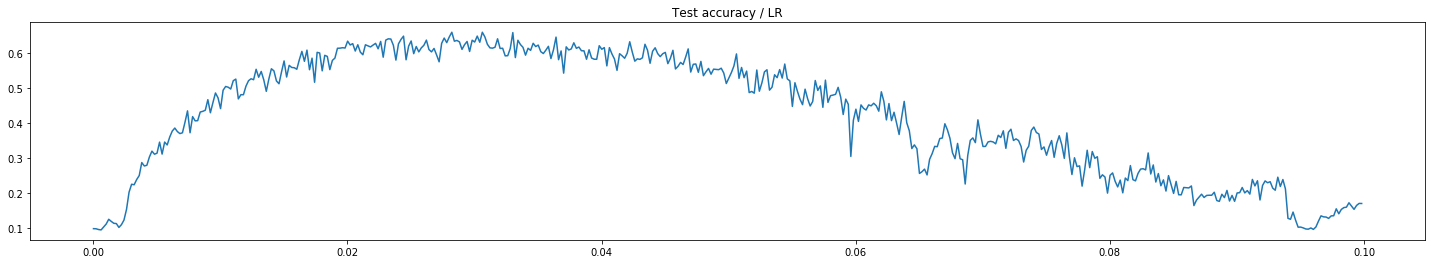

In [7]:
%%time

n_epochs = 10
lr_min = 0.001
lr_max = 0.1


model = CNN().to(device)
optimiser = SGD(model.parameters(), lr=lr_min, momentum=.9)
scheduler = LambdaLR(optimiser, lambda it: it * lr_max / (n_epochs * len(train_loader) * lr_min))

logger = train(model, optimiser, scheduler, n_epochs)
                
plt.title("Test accuracy / LR")
plt.plot(logger["lr"], logger["test_acc"])
plt.show()

### 2.2 Benchmarking
- Using triangular2 policy
- Comparing: SGD, SGD_CLR, ADAM

In [22]:
base_model = CNN()
n_epochs = 20

#### 2.2.1 SGD

In [23]:
model = copy.deepcopy(base_model).to(device)

optimiser = SGD(model.parameters(), lr=0.005, momentum=.9)
scheduler = None
sgd = train(model, optimiser, scheduler, n_epochs)

#### 2.2.2 SGD + CLR

In [24]:
lr_min = 0.005
lr_max = 0.030
model = copy.deepcopy(base_model).to(device)

optimiser = SGD(model.parameters(), lr=lr_min, momentum=.9)
scheduler = CyclicLR(optimiser, base_lr=lr_min, max_lr=lr_max, step_size_up=2 * len(train_loader), mode="triangular2")
sgd_clr = train(model, optimiser, scheduler, n_epochs)

#### 2.2.3 Adam

In [25]:
model = copy.deepcopy(base_model).to(device)

optimiser = Adam(model.parameters())
scheduler = None
adam = train(model, optimiser, scheduler, n_epochs)

### 2.3 Results
- CLR performs better indeed

Final SGD_CLR: 0.7501
Final SGD: 0.7383
Final Adam: 0.7371



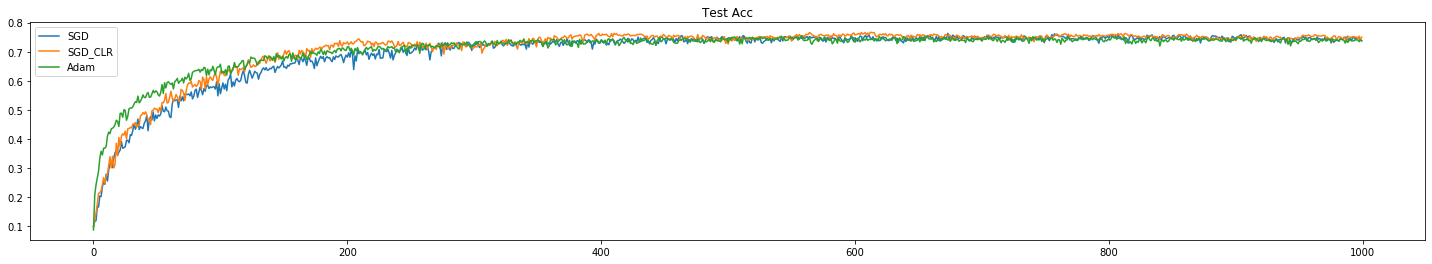

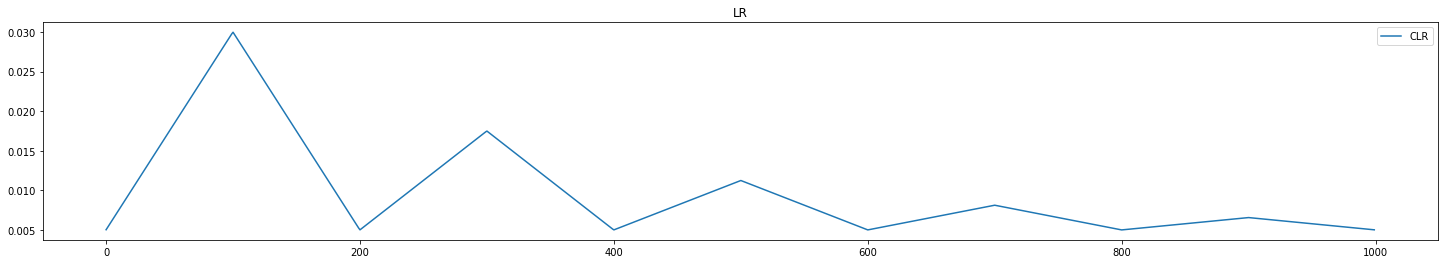

In [27]:
print(f"Final SGD_CLR: {sgd_clr['test_acc'][-1]}")
print(f"Final SGD: {sgd['test_acc'][-1]}")
print(f"Final Adam: {adam['test_acc'][-1]}\n")

plt.title("Test Acc")
plt.plot(sgd["test_acc"], label="SGD")
plt.plot(sgd_clr["test_acc"], label="SGD_CLR")
plt.plot(adam["test_acc"], label="Adam")
plt.legend()
plt.show()

plt.title("LR")
plt.plot(sgd_clr["lr"], label="CLR")
plt.legend()
plt.show()

## 3. Training Stability
- How reproducible are results with more runs/initialisations
- Seems to be quite stable, all converge and have results within 1.5% of each other

Trial 0 final acc: 0.7602
Trial 1 final acc: 0.747
Trial 2 final acc: 0.7607
Trial 3 final acc: 0.7577
Trial 4 final acc: 0.746
Final acc std: 0.006473144521791566


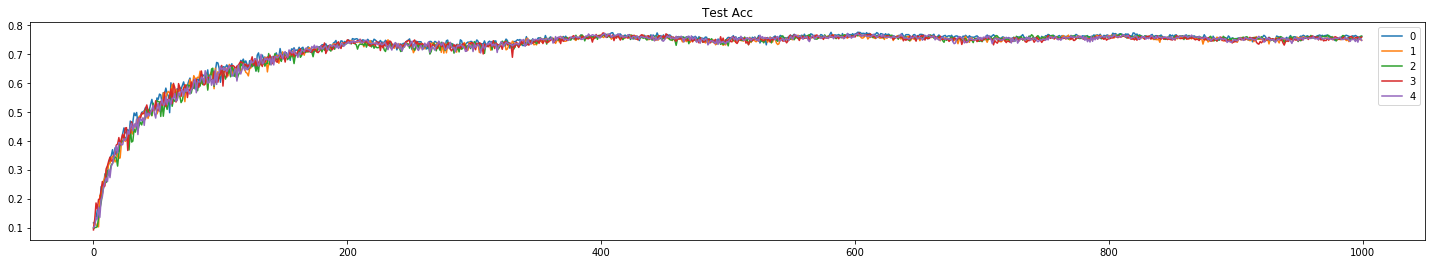

In [37]:
lr_min = 0.005
lr_max = 0.030
n_trials = 5

logs = []
for _ in range(n_trials):
    model = CNN().to(device)
    optimiser = SGD(model.parameters(), lr=lr_min, momentum=.9)
    scheduler = CyclicLR(optimiser, base_lr=lr_min, max_lr=lr_max, step_size_up=2 * len(train_loader), mode="triangular2")
    sgd_clr = train(model, optimiser, scheduler, n_epochs)
    logs.append(sgd_clr["test_acc"])
    

plt.title("Test Acc")
for ix, res in enumerate(logs):
    print(f"Trial {ix} final acc: {res[-1]}")
    plt.plot(res, label=str(ix))
print(f"Final acc std: {np.std([res[-1] for res in logs])}")
plt.legend()
plt.show()

## 4. Parameter Sensitivity
- How sensitive is CLR to hyperparameter choice
- Same initialised network

Trial 0 final acc: 0.7616
Trial 1 final acc: 0.7394
Trial 2 final acc: 0.7599
Trial 3 final acc: 0.7437
Trial 4 final acc: 0.7458
Trial 5 final acc: 0.7302


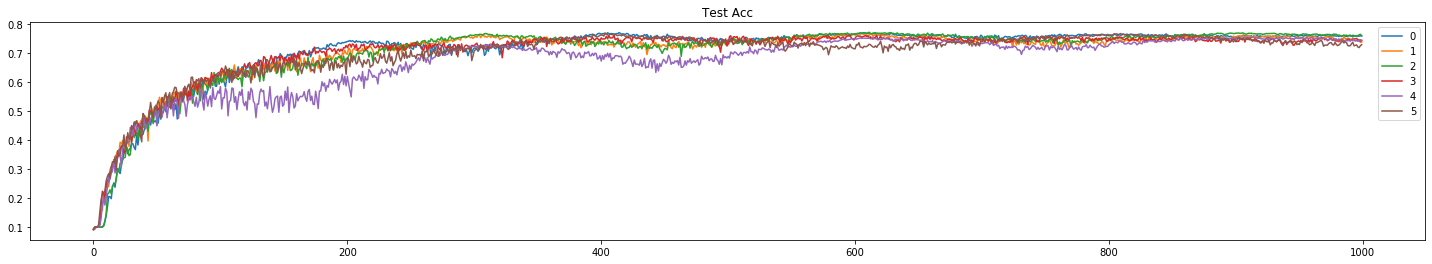

In [39]:
base_model = CNN()

params = [
    {"lr_min": 0.001, "lr_max": 0.03, "stepsize": 2},
    {"lr_min": 0.005, "lr_max": 0.04, "stepsize": 3},
    {"lr_min": 0.001, "lr_max": 0.05, "stepsize": 3},
    {"lr_min": 0.005, "lr_max": 0.02, "stepsize": 2},
    {"lr_min": 0.001, "lr_max": 0.10, "stepsize": 3},
    {"lr_min": 0.005, "lr_max": 0.05, "stepsize": 4},
]

logs = []
for param in params:
    model = copy.deepcopy(base_model).to(device)
    
    optimiser = SGD(model.parameters(), lr=lr_min, momentum=.9)
    scheduler = CyclicLR(optimiser, base_lr=param["lr_min"], max_lr=param["lr_max"], step_size_up=param["stepsize"] * len(train_loader), mode="triangular2")
    sgd_clr = train(model, optimiser, scheduler, n_epochs)
    
    logs.append(sgd_clr["test_acc"])
    
    
plt.title("Test Acc")
for ix, res in enumerate(logs):
    print(f"Trial {ix} final acc: {res[-1]}")
    plt.plot(res, label=str(ix))
plt.legend()
plt.show()